In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# With real data

Using the model with KDE estimates for background and trigger, but with the trigger split between space and time.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_full
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout()
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, collections, os
import open_cp.predictors
import sepp.kernels
import scipy.stats
import opencrimedata.chicago

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

## Plotting functions

In [6]:
from plotting_split import *

## Nearest neighbour, variable bandwidth

In [7]:
tk_time_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
tk_space_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
back_ker_prov = sepp.kernels.NearestNeighbourKernelProvider(20)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.train(datetime.datetime(2018,1,1), iterations=5)
model

Model1(T=730.9583333333334, mu=1.206992881561565, background=<open_cp.kernels.GaussianNearestNeighbour object at 0x000001B65E253EF0>, theta=0.28734934971612336, trigger=<open_cp.kernels.Reflect1D object at 0x000001B6663ED438>,<open_cp.kernels.GaussianNearestNeighbour object at 0x000001B6663EDDD8>

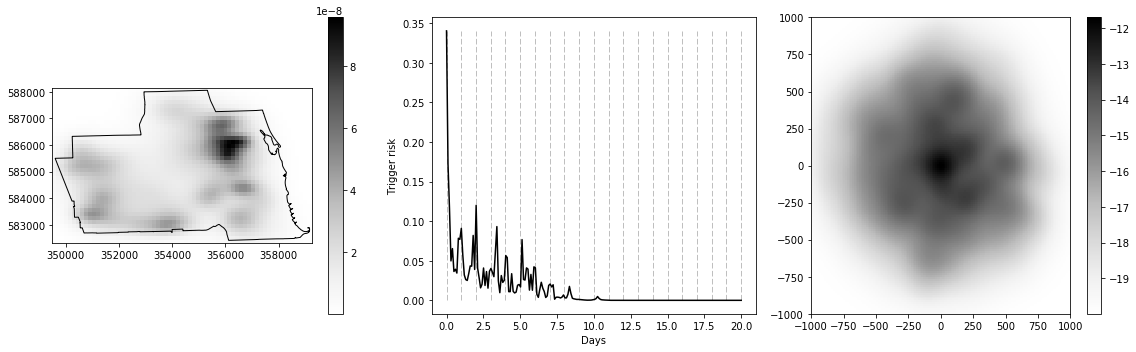

In [10]:
fig = plot(model, space_size=1000, time_size=20, space_floor=np.exp(-20))

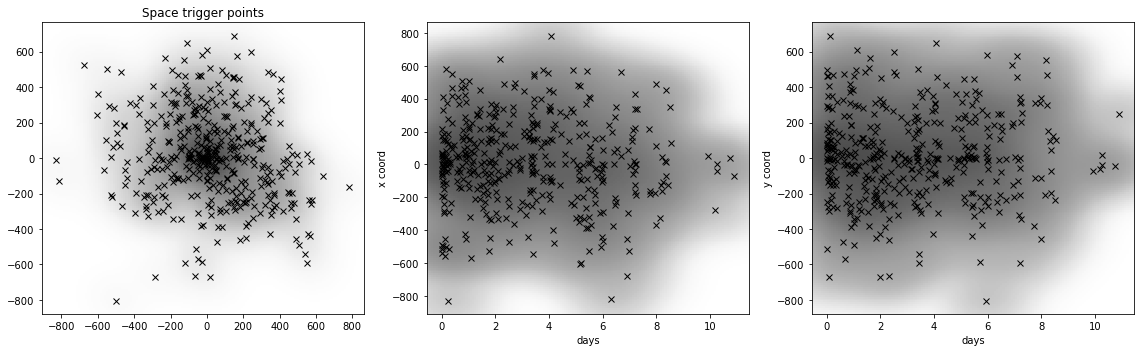

In [9]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

This gets very, very slow: each iteration taking a couple of hours...

## Stochastic EM

In [9]:
tk_time_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
tk_space_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
back_ker_prov = sepp.kernels.NearestNeighbourKernelProvider(20)
opt_fac = sepp.sepp_full.Optimiser1SEMFactory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac) 
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.train(datetime.datetime(2018,1,1), iterations=15)
model

Model1(T=730.9583333333334, mu=0.03364432951248336, background=<open_cp.kernels.GaussianNearestNeighbour object at 0x000001A9E358C0B8>, theta=0.9801352156489805, trigger=<open_cp.kernels.Reflect1D object at 0x000001A9E359E6D8>,<open_cp.kernels.GaussianNearestNeighbour object at 0x000001A9E359E710>

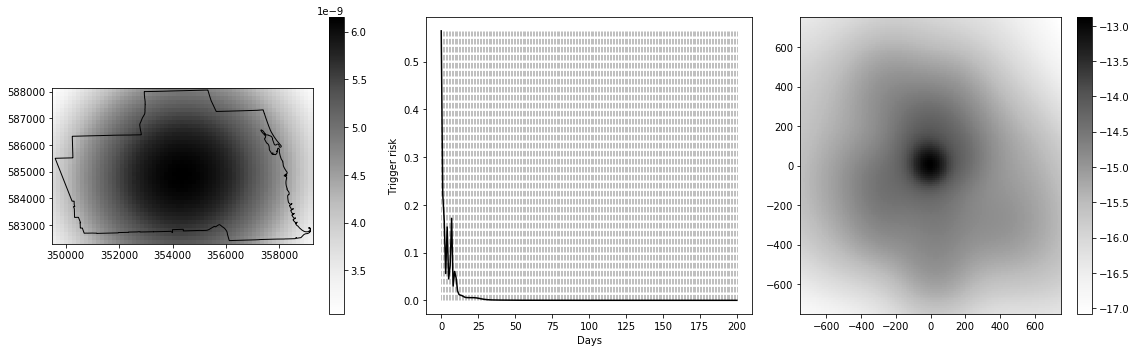

In [10]:
fig = plot(model, space_size=750, time_size=200, space_floor=np.exp(-20))

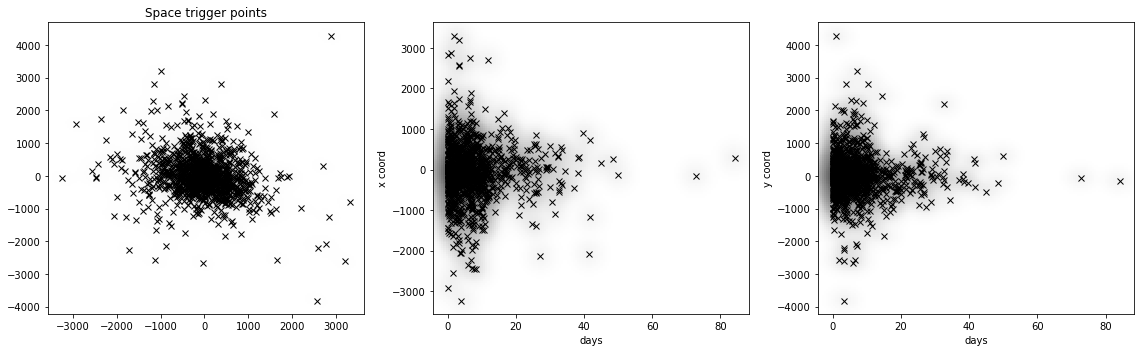

In [11]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [13]:
backgrounds, trigger_deltas = trainer.sample_to_points(model, datetime.datetime(2017,1,1))
backgrounds.shape, trigger_deltas.shape

((3, 7), (3, 1231))

## Nearest neighbour

Now with k=15 for spatial components

In [11]:
tk_time_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
tk_space_prov = sepp.kernels.NearestNeighbourKernelProvider(15)
back_ker_prov = sepp.kernels.NearestNeighbourKernelProvider(15)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.train(datetime.datetime(2018,1,1), iterations=5)
model

Model1(T=730.9583333333334, mu=1.2654811374755641, background=<open_cp.kernels.GaussianNearestNeighbour object at 0x0000025727CD6668>, theta=0.2528158456268908, trigger=<open_cp.kernels.Reflect1D object at 0x000002572B2569B0>,<open_cp.kernels.GaussianNearestNeighbour object at 0x000002572A88DE48>

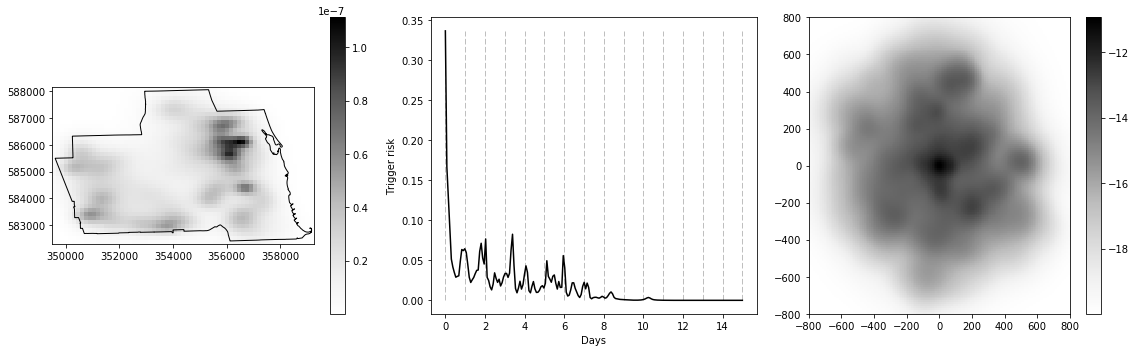

In [12]:
fig = plot(model, space_size=800, time_size=15, space_floor=np.exp(-20), geo=northside, grid=grid)

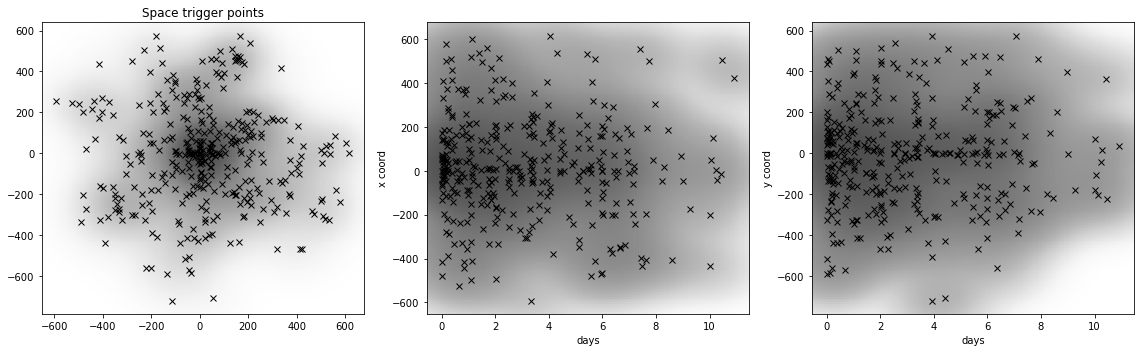

In [13]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [14]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()

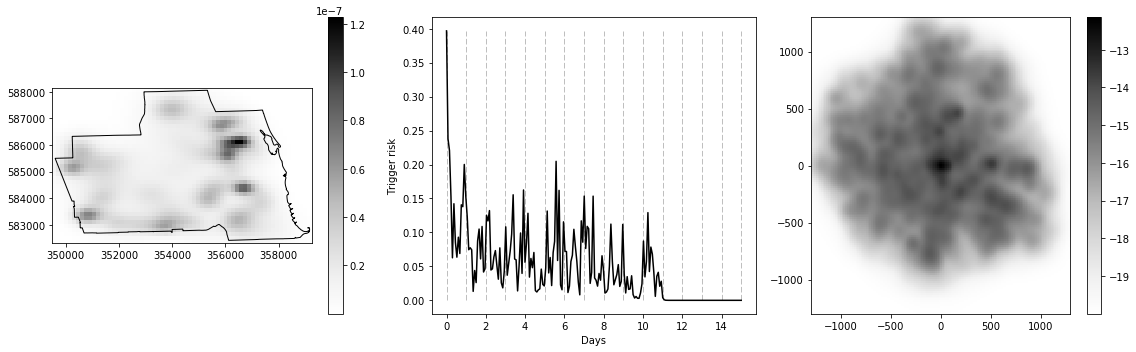

In [18]:
fig = plot(model, space_size=1300, time_size=15, space_floor=np.exp(-20), geo=northside, grid=grid)

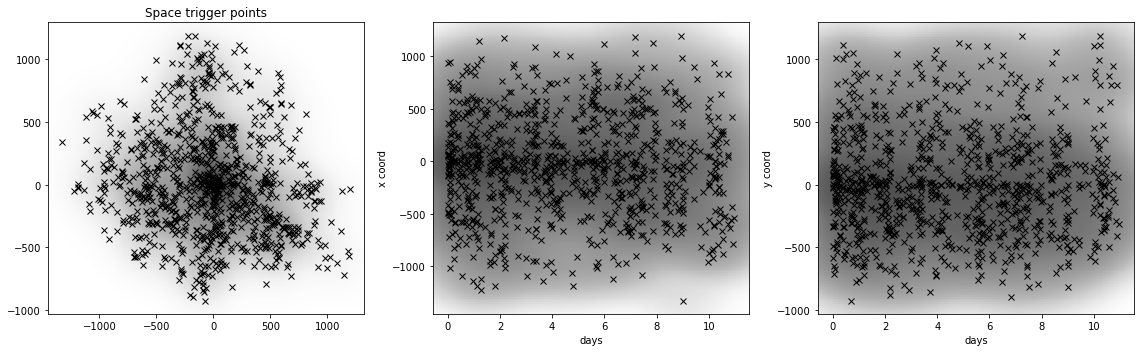

In [16]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

### Stochastic EM

In [7]:
tk_time_prov = sepp.kernels.NearestNeighbourKernelProvider(30)
tk_space_prov = sepp.kernels.NearestNeighbourKernelProvider(15)
back_ker_prov = sepp.kernels.NearestNeighbourKernelProvider(15)
opt_fac = sepp.sepp_full.Optimiser1SEMFactory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac) 
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.train(datetime.datetime(2018,1,1), iterations=15)
model

Model1(T=730.9583333333334, mu=0.06077057322669833, background=<open_cp.kernels.GaussianNearestNeighbour object at 0x000001AC726E3470>, theta=0.9641189362508099, trigger=<open_cp.kernels.Reflect1D object at 0x000001AC75E30A58>,<open_cp.kernels.GaussianNearestNeighbour object at 0x000001AC75E30278>

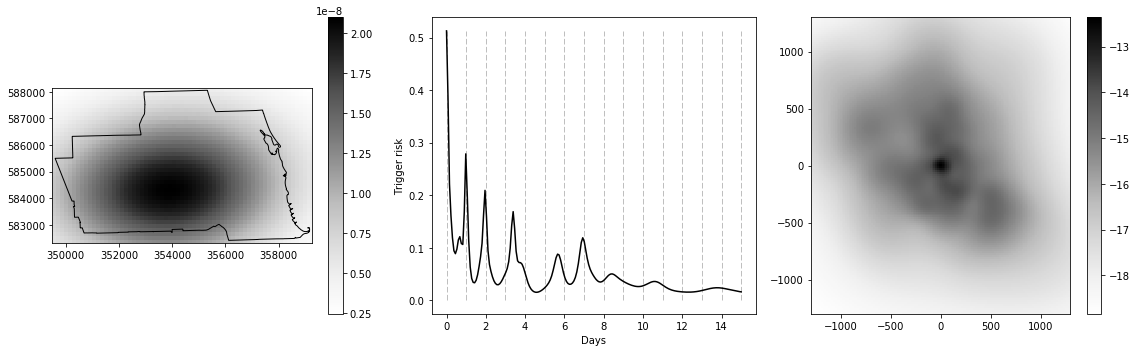

In [8]:
fig = plot(model, space_size=1300, time_size=15, space_floor=np.exp(-20), geo=northside, grid=grid)

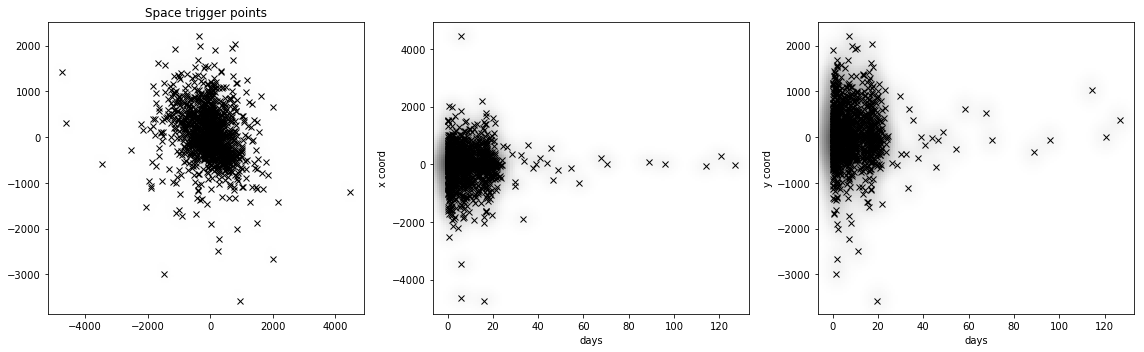

In [9]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))